<a href="https://colab.research.google.com/github/rieldata1/deep-clustering-rails/blob/main/Deep_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configurar GPU y activar high-RAM**

In [44]:
# Montar Drive
from google import colab
colab.drive.mount('/content/drive')
print("")

# Configurar GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Activar high-RAM
import psutil
ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Tue Sep  2 21:39:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   72C    P0             34W /   72W |     973MiB /  23034MiB |      0%      Default |
|         

# **Deep_Clustering: carga NPZ + AE + K-sweep + DEC (+ IDEC)**
* Este notebook consumirá los NPZ generados por "Scalograms".


## **0. Preeliminares**

In [45]:
# ============================================================
#  PRELIMINARES: Parámetros + Imports + Runtime/Device + Utils
#  Este notebook consume los .npz generados por "Scalograms".
# ============================================================

# -----------------------------
# PARÁMETROS (ajusta aquí)
# -----------------------------
BASE_DIR           = "/content/drive/MyDrive/Deep_Cluster"
EXPERIMENTS_DIR    = f"{BASE_DIR}/experiments"

# Datos
PRELOAD_DATA       = True         # intentar precargar todos los .npz si caben en RAM
PRELOAD_MAX_GB     = 4.0          # umbral aprox para decidir precarga
IMG_NORMALIZE_AGAIN= False        # renormalizar [0,1] al vuelo (en general no hace falta)

# DataLoader
BATCH_AE           = 64
BATCH_EMB          = 128
BATCH_DEC          = 64
NUM_WORKERS        = 2
PIN_MEMORY         = True
PERSISTENT_WORKERS = True

# Modelo / Entrenamiento
LATENT_DIM         = 128
BACKBONE           = "base"       # 'small' | 'base' | 'large'
DROPOUT_P          = 0.0

AE_EPOCHS          = 20
AE_LR              = 1e-3
AE_WD              = 1e-5
AE_LOSS            = "l1"         # 'l1' o 'mse'
USE_AMP            = True         # mixed precision en GPU (dtype explícito)

# Barrido de K
K_MIN              = 2
K_MAX              = 10
K_FIXED            = None         # si lo fijas, salta el barrido (ej. 4)
K_RANDOM_STATE     = 2025

# DEC
DEC_EPOCHS         = 40
DEC_LR             = 1e-4
DEC_WD             = 0.0
DEC_UPDATE_INT     = 1
DEC_TOL            = 1e-3

# IDEC (opcional) — lo añadiremos en una celda siguiente si lo activas
RUN_IDEC           = False
IDEC_EPOCHS        = 40
IDEC_LR            = 1e-4
IDEC_WD            = 0.0
IDEC_LAMBDA_REC    = 1e-2
IDEC_UPDATE_INT    = 1
IDEC_TOL           = 1e-3

# Visualización / Guardado
RUN_TSNE_2D        = True
TSNE_PERPLEXITY    = 30
SEED               = 2025
SAVE_ARTIFACTS     = True

# -----------------------------
# IMPORTS
# -----------------------------
import os, time, csv, math, gc, json, random, glob, bisect
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm  # no 'auto' → evita widgets (GitHub render ok)

# Helper para KMeans sin FutureWarnings y compatible con varias versiones
def _kmeans(n_clusters, random_state=2025):
    """
    KMeans con n_init explícito:
    - si la versión soporta n_init="auto", lo usa (sin warning)
    - si no, cae a n_init=10 (compatibilidad hacia atrás)
    """
    try:
        return KMeans(n_clusters=n_clusters, n_init="auto", random_state=random_state)
    except TypeError:
        return KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)

# -----------------------------
# Runtime / Device
# -----------------------------
def seed_everything(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    if hasattr(torch, "set_float32_matmul_precision"):
        torch.set_float32_matmul_precision("high")

seed_everything(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Dispositivo:", torch.cuda.get_device_name(0) if DEVICE.type=="cuda" else "CPU")

os.makedirs(EXPERIMENTS_DIR, exist_ok=True)
RUN_DIR = os.path.join(EXPERIMENTS_DIR, datetime.now().strftime("run_%Y%m%d_%H%M%S"))
os.makedirs(RUN_DIR, exist_ok=True)
print("Carpeta de ejecución:", RUN_DIR)

# -----------------------------
# Utils
# -----------------------------
def sizeof_gb(n_items, h, w, bytes_per=2):
    """Tamaño estimado (GB) para n_items imágenes HxW en float{bytes_per}."""
    return (n_items * h * w * bytes_per) / (1024**3)

def count_params(m):
    """Parámetros entrenables del modelo."""
    return sum(p.numel() for p in m.parameters() if p.requires_grad)


✅ Dispositivo: NVIDIA L4
Carpeta de ejecución: /content/drive/MyDrive/Deep_Cluster/experiments/run_20250902_213956


## **1) Conjunto de datos**

[SCAN] .npz encontrados: 29
  • /content/drive/MyDrive/Deep_Cluster/data/scalos_train_000.npz
  • /content/drive/MyDrive/Deep_Cluster/data/scalos_train_001.npz
  • /content/drive/MyDrive/Deep_Cluster/data/scalos_train_002.npz
  • …
[MANIFEST] Ventanas=1800 | HxW=256x256
[MEM] ~0.22 GB | Preload=True (umbral=4.0 GB)
[LOAD] Precargando .npz a RAM…


Precarga: 100%|██████████| 29/29 [00:01<00:00, 15.45it/s]


[DATA] Train=1440 | Val=360 | Total=1800 | HxW=256x256


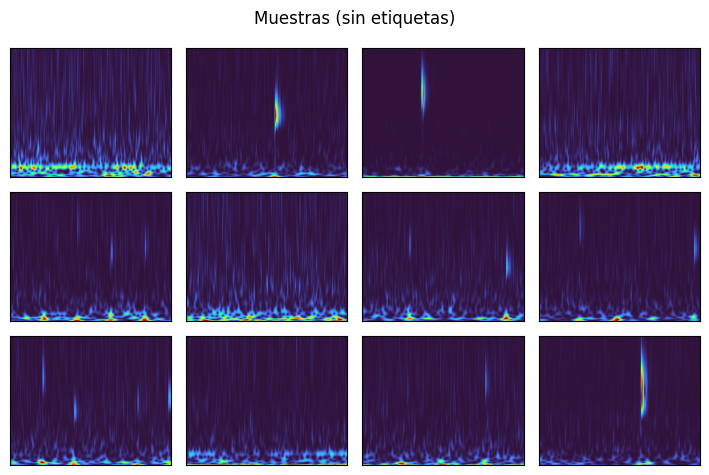

In [46]:
# ============================================================
# 1) DATASET (no supervisado): descubre .npz y carga escalogramas
# ============================================================
DATA_DIR = os.path.join(BASE_DIR, "data")
npz_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.npz")))
if not npz_files:
    raise FileNotFoundError(f"No hay .npz en {DATA_DIR}. ¿Ya corriste 'Scalograms'?")

print(f"[SCAN] .npz encontrados: {len(npz_files)}")
for p in npz_files[:3]: print("  •", p)
if len(npz_files) > 3: print("  • …")

class NPZManifest:
    """Escanea .npz → total de ventanas, HxW, y mapeo índice global → (archivo, índice local)."""
    def __init__(self, files):
        self.files = list(files)
        self.counts, self.cumcounts = [], [0]
        self.img_h = None; self.img_w = None
        for p in self.files:
            d = np.load(p, allow_pickle=True)
            X = d["X"]  # (B,H,W)
            B, H, W = X.shape
            self.counts.append(B)
            self.cumcounts.append(self.cumcounts[-1] + B)
            if self.img_h is None:
                self.img_h, self.img_w = int(H), int(W)
            else:
                if (self.img_h, self.img_w) != (int(H), int(W)):
                    raise ValueError(f"Tamaños inconsistentes: {p} {(H,W)} vs {(self.img_h,self.img_w)}")
        self.total = self.cumcounts[-1]

    def __len__(self): return self.total

    def locate(self, global_idx):
        file_idx = bisect.bisect_right(self.cumcounts, global_idx) - 1
        local_idx = global_idx - self.cumcounts[file_idx]
        return self.files[file_idx], int(local_idx)

manifest = NPZManifest(npz_files)
print(f"[MANIFEST] Ventanas={len(manifest)} | HxW={manifest.img_h}x{manifest.img_w}")

# Estimar si conviene precargar
est_gb = sizeof_gb(len(manifest), manifest.img_h, manifest.img_w, bytes_per=2)  # float16
do_preload = PRELOAD_DATA and (est_gb <= PRELOAD_MAX_GB + 1e-9)
print(f"[MEM] ~{est_gb:.2f} GB | Preload={do_preload} (umbral={PRELOAD_MAX_GB} GB)")

class ScalogramUnsupervisedDS(Dataset):
    """Devuelve (x, '_') con x → tensor (1,H,W) en [0,1]. Sin etiquetas."""
    def __init__(self, manifest: NPZManifest, preload=False, normalize_again=False):
        self.manifest = manifest
        self.normalize_again = normalize_again
        self.preload = preload
        self.cache = {}
        if self.preload:
            print("[LOAD] Precargando .npz a RAM…")
            for p in tqdm(self.manifest.files, desc="Precarga"):
                self.cache[p] = np.load(p, allow_pickle=True)["X"]  # (B,H,W) float16

    def __len__(self): return len(self.manifest)

    def __getitem__(self, i):
        p, j = self.manifest.locate(i)
        Xj = self.cache[p][j] if p in self.cache else np.load(p, allow_pickle=True)["X"][j]
        x = torch.from_numpy(np.asarray(Xj, dtype=np.float32)).unsqueeze(0)  # (1,H,W)
        if IMG_NORMALIZE_AGAIN:
            mn, mx = x.min(), x.max()
            x = (x - mn) / (mx - mn + 1e-12)
            x.clamp_(0.0, 1.0)
        return x, "_"  # placeholder sin etiquetas

# Instanciar dataset y splits 80/20
ds_all = ScalogramUnsupervisedDS(manifest, preload=do_preload, normalize_again=IMG_NORMALIZE_AGAIN)
rng = np.random.default_rng(SEED)
perm = rng.permutation(len(ds_all))
n_tr = int(0.8 * len(ds_all))
idx_tr, idx_va = perm[:n_tr], perm[n_tr:]

ds_train = Subset(ds_all, idx_tr)
ds_val   = Subset(ds_all, idx_va)

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH_AE, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                      persistent_workers=(NUM_WORKERS>0 and PERSISTENT_WORKERS),
                      drop_last=False)
dl_val   = DataLoader(ds_val, batch_size=BATCH_AE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                      persistent_workers=(NUM_WORKERS>0 and PERSISTENT_WORKERS),
                      drop_last=False)
def make_all_loader(ds, bs=BATCH_EMB):
    return DataLoader(ds, batch_size=bs, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                      persistent_workers=(NUM_WORKERS>0 and PERSISTENT_WORKERS),
                      drop_last=False)
dl_all = make_all_loader(ds_all, bs=BATCH_EMB)

print(f"[DATA] Train={len(ds_train)} | Val={len(ds_val)} | Total={len(ds_all)} | HxW={manifest.img_h}x{manifest.img_w}")

def show_grid_samples(dataset, n=12, rows=3, cols=4, title="Muestras (sin etiquetas)"):
    n = min(n, len(dataset), rows*cols)
    fig, axes = plt.subplots(rows, cols, figsize=(1.8*cols, 1.6*rows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1)
    idxs = rng.choice(len(dataset), size=n, replace=False)
    for k, i in enumerate(idxs):
        x, _ = dataset[i]
        axes[k].imshow(x.squeeze(0).numpy(), origin="lower", aspect="auto", cmap="turbo")
        axes[k].set_xticks([]); axes[k].set_yticks([])
    for a in axes[n:]: a.axis("off")
    fig.suptitle(title); plt.tight_layout(); plt.show()
show_grid_samples(ds_all)


## **2) Modelo Autoencoder + Capa de Clustering**

In [47]:
# ============================================================
# 2) MODELO: Autoencoder conv + Capa de Clustering (Student-t)
# ============================================================

def make_channels(backbone: str):
    if backbone == "small": return [32, 64, 128, 256]
    if backbone == "large": return [64, 128, 256, 512]
    return [32, 64, 128, 256]  # 'base'

class ConvEncoder(nn.Module):
    def __init__(self, img_size, latent_dim=128, dropout_p=0.0, backbone="base"):
        super().__init__()
        C = make_channels(backbone)
        self.stem = nn.Sequential(
            nn.Conv2d(1,   C[0], 3, 2, 1), nn.BatchNorm2d(C[0]), nn.ReLU(inplace=True),
            nn.Conv2d(C[0],C[1], 3, 2, 1), nn.BatchNorm2d(C[1]), nn.ReLU(inplace=True),
            nn.Conv2d(C[1],C[2], 3, 2, 1), nn.BatchNorm2d(C[2]), nn.ReLU(inplace=True),
            nn.Conv2d(C[2],C[3], 3, 2, 1), nn.BatchNorm2d(C[3]), nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_p)
        )
        H, W = img_size
        with torch.no_grad():
            dummy = torch.zeros(1, 1, H, W)
            f = self.stem(dummy)  # (1, C[-1], H', W')
        self._feat_shape = f.shape
        c_last, h_last, w_last = f.shape[1], f.shape[2], f.shape[3]
        self.proj = nn.Linear(c_last * h_last * w_last, latent_dim)

    def forward(self, x):
        f = self.stem(x)
        z = self.proj(f.flatten(1))
        return z

class ConvDecoder(nn.Module):
    def __init__(self, feat_shape, latent_dim=128, dropout_p=0.0, backbone="base"):
        super().__init__()
        C = make_channels(backbone)
        c_last, h_last, w_last = feat_shape[1], feat_shape[2], feat_shape[3]
        self.fc = nn.Linear(latent_dim, c_last * h_last * w_last)
        self.head = nn.Sequential(
            nn.ConvTranspose2d(c_last, C[2], 4, 2, 1), nn.BatchNorm2d(C[2]), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(C[2], C[1], 4, 2, 1),   nn.BatchNorm2d(C[1]), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(C[1], C[0], 4, 2, 1),   nn.BatchNorm2d(C[0]), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(C[0], 1,     4, 2, 1),
            nn.Sigmoid()  # salida en [0,1]
        )
        self._feat_shape = (1, c_last, h_last, w_last)

    def forward(self, z):
        f = self.fc(z).view(z.size(0), *self._feat_shape[1:])
        xrec = self.head(f)
        return xrec

class ConvAutoencoder(nn.Module):
    def __init__(self, img_size, latent_dim=128, dropout_p=0.0, backbone="base"):
        super().__init__()
        self.encoder = ConvEncoder(img_size, latent_dim, dropout_p, backbone)
        self.decoder = ConvDecoder(self.encoder._feat_shape, latent_dim, dropout_p, backbone)
    def forward(self, x):
        z = self.encoder(x); xr = self.decoder(z); return z, xr

class ClusteringLayer(nn.Module):
    """Capa de clustering con kernel t-Student (DEC)."""
    def __init__(self, n_clusters, latent_dim, alpha=1.0):
        super().__init__()
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.cluster_centers = nn.Parameter(torch.randn(n_clusters, latent_dim))
    @torch.no_grad()
    def set_centers(self, centers_np):
        self.cluster_centers.copy_(torch.as_tensor(centers_np, dtype=torch.float32))
    def forward(self, z):
        z_exp  = z.unsqueeze(1)                        # (B,1,L)
        mu_exp = self.cluster_centers.unsqueeze(0)     # (1,K,L)
        dist2  = torch.sum((z_exp - mu_exp)**2, dim=2) # (B,K)
        num    = (1.0 + dist2 / self.alpha) ** (-(self.alpha + 1.0)/2.0)
        q      = num / torch.sum(num, dim=1, keepdim=True)
        return q

# Instanciar modelo y capa de clustering
IMG_H, IMG_W = manifest.img_h, manifest.img_w
ae = ConvAutoencoder(img_size=(IMG_H, IMG_W), latent_dim=LATENT_DIM,
                     dropout_p=DROPOUT_P, backbone=BACKBONE).to(DEVICE)
cluster_layer = ClusteringLayer(n_clusters=max(2, K_MIN), latent_dim=LATENT_DIM, alpha=1.0).to(DEVICE)

print(f"[MODEL] AE params: {count_params(ae):,} | Clustering params: {count_params(cluster_layer):,}")
xb, _ = next(iter(dl_train))
xb = xb.to(DEVICE, non_blocking=True)
with torch.no_grad():
    z, xr = ae(xb)
print(f"[CHECK] Batch: in {tuple(xb.shape)} → z {tuple(z.shape)} → recon {tuple(xr.shape)}")


[MODEL] AE params: 17,920,993 | Clustering params: 256
[CHECK] Batch: in (64, 1, 256, 256) → z (64, 128) → recon (64, 1, 256, 256)


## **3. Pre-entrenamiento del AutoEncoder + extracción de embeddings (Z)**

[AE] ep 01/20 | train=0.2766 | val=0.1324 | lr=1.00e-03 | 1.2s


[AE] ep 02/20 | train=0.1293 | val=0.0847 | lr=1.00e-03 | 1.1s


[AE] ep 03/20 | train=0.0779 | val=0.0530 | lr=1.00e-03 | 1.1s


[AE] ep 04/20 | train=0.0400 | val=0.0221 | lr=1.00e-03 | 1.1s


[AE] ep 05/20 | train=0.0205 | val=0.0177 | lr=1.00e-03 | 1.2s


[AE] ep 06/20 | train=0.0165 | val=0.0163 | lr=1.00e-03 | 1.1s


[AE] ep 07/20 | train=0.0154 | val=0.0155 | lr=1.00e-03 | 1.1s


[AE] ep 08/20 | train=0.0149 | val=0.0152 | lr=1.00e-03 | 1.1s


[AE] ep 09/20 | train=0.0145 | val=0.0149 | lr=1.00e-03 | 1.1s


[AE] ep 10/20 | train=0.0144 | val=0.0148 | lr=1.00e-03 | 1.1s


[AE] ep 11/20 | train=0.0142 | val=0.0146 | lr=1.00e-03 | 1.1s


[AE] ep 12/20 | train=0.0140 | val=0.0146 | lr=1.00e-03 | 1.1s


[AE] ep 13/20 | train=0.0139 | val=0.0144 | lr=1.00e-03 | 1.1s


[AE] ep 14/20 | train=0.0138 | val=0.0144 | lr=1.00e-03 | 1.2s


[AE] ep 15/20 | train=0.0137 | val=0.0143 | lr=1.00e-03 | 1.2s


[AE] ep 16/20 | train=0.0136 | val=0.0143 | lr=1.00e-03 | 1.2s


[AE] ep 17/20 | train=0.0136 | val=0.0153 | lr=1.00e-03 | 1.1s


[AE] ep 18/20 | train=0.0136 | val=0.0140 | lr=1.00e-03 | 1.1s


[AE] ep 19/20 | train=0.0133 | val=0.0138 | lr=1.00e-03 | 1.2s


[AE] ep 20/20 | train=0.0131 | val=0.0137 | lr=1.00e-03 | 1.1s


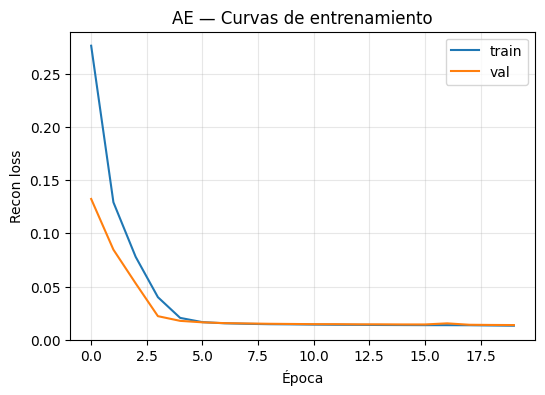

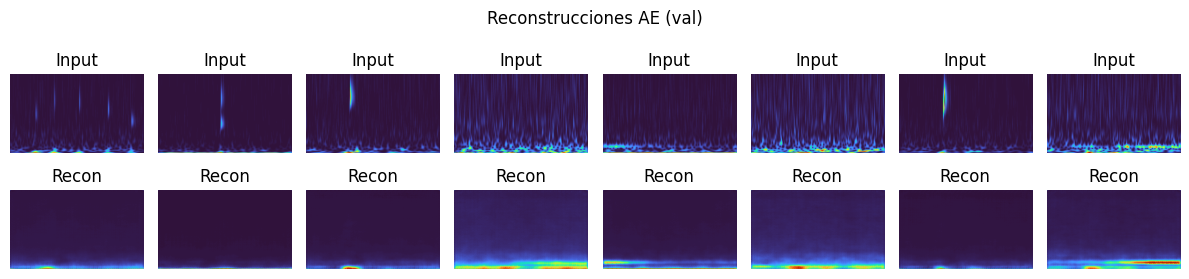

Embeddings Z_all: (1800, 128)


In [48]:
# ============================================================
# 3) PREENTRENAMIENTO DEL AE (AMP nueva API) + EXTRACCIÓN DE Z
# ============================================================
import gc, time
from contextlib import nullcontext

def _amp_enabled():
    return bool(USE_AMP and DEVICE.type == "cuda")

def _amp_ctx():
    # API nueva: torch.amp.autocast('cuda', ...)
    return torch.amp.autocast("cuda", dtype=torch.float16) if _amp_enabled() else nullcontext()

def _make_scaler():
    # API nueva: torch.amp.GradScaler('cuda')
    return torch.amp.GradScaler("cuda") if _amp_enabled() else None

def train_autoencoder(
    ae, dl_train, dl_val,
    epochs=AE_EPOCHS, lr=AE_LR, wd=AE_WD,
    use_amp=USE_AMP, loss_name=AE_LOSS, device=DEVICE,
):
    ae = ae.to(device).train()
    opt = torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=4)
    criterion = nn.MSELoss() if str(loss_name).lower()=="mse" else nn.L1Loss()

    scaler = _make_scaler()
    hist = {"train": [], "val": [], "lr": []}
    best_val, best_state = float("inf"), None

    for ep in range(1, epochs+1):
        t0 = time.time()

        # ---------- TRAIN ----------
        ae.train(); tr_loss, ntr = 0.0, 0
        for xb, _ in tqdm(dl_train, desc=f"[AE][{ep:02d}/{epochs}] Train", leave=False):
            xb = xb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with _amp_ctx():
                z, xr = ae(xb)
                loss = criterion(xr, xb)

            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update()
            else:
                loss.backward(); opt.step()

            tr_loss += loss.item()*xb.size(0); ntr += xb.size(0)
        tr_loss /= max(1, ntr)

        # ---------- VAL ----------
        ae.eval(); va_loss, nva = 0.0, 0
        with torch.no_grad():
            for xb, _ in tqdm(dl_val, desc=f"[AE][{ep:02d}/{epochs}] Val  ", leave=False):
                xb = xb.to(device, non_blocking=True)
                with _amp_ctx():
                    _, xr = ae(xb)
                    vl = criterion(xr, xb)
                va_loss += vl.item()*xb.size(0); nva += xb.size(0)
        va_loss /= max(1, nva)

        # Scheduler y log
        prev_lr = opt.param_groups[0]["lr"]
        scheduler.step(va_loss)
        lr_now = opt.param_groups[0]["lr"]
        if lr_now < prev_lr:
            print(f"   ↘ LR: {prev_lr:.2e} → {lr_now:.2e}")

        hist["train"].append(tr_loss); hist["val"].append(va_loss); hist["lr"].append(lr_now)
        print(f"[AE] ep {ep:02d}/{epochs} | train={tr_loss:.4f} | val={va_loss:.4f} | lr={lr_now:.2e} | {time.time()-t0:.1f}s")

        if va_loss < best_val - 1e-6:
            best_val = va_loss
            best_state = {k:v.detach().cpu().clone() for k,v in ae.state_dict().items()}

        torch.cuda.empty_cache(); gc.collect()

    if best_state is not None:
        ae.load_state_dict(best_state)
    return ae, hist

# --- Entrenar AE ---
ae, hist_ae = train_autoencoder(ae, dl_train, dl_val,
                                epochs=AE_EPOCHS, lr=AE_LR, wd=AE_WD,
                                use_amp=USE_AMP, loss_name=AE_LOSS, device=DEVICE)

# --- Curvas ---
plt.figure(figsize=(6,4))
plt.plot(hist_ae["train"], label="train")
plt.plot(hist_ae["val"], label="val")
plt.xlabel("Época"); plt.ylabel("Recon loss"); plt.title("AE — Curvas de entrenamiento")
plt.grid(alpha=0.3); plt.legend(); plt.show()

# --- Reconstrucciones rápidas ---
ae.eval()
with torch.no_grad():
    xb, _ = next(iter(dl_val))
    xb = xb.to(DEVICE, non_blocking=True)
    _, xr = ae(xb[:8])
xb = xb[:8].cpu().numpy(); xr = xr.cpu().numpy()

rows, cols = 2, min(8, xb.shape[0])
fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols, 2.8))
for i in range(cols):
    axes[0, i].imshow(xb[i,0], origin="lower", aspect="auto", cmap="turbo"); axes[0, i].set_title("Input");  axes[0, i].axis("off")
    axes[1, i].imshow(xr[i,0], origin="lower", aspect="auto", cmap="turbo"); axes[1, i].set_title("Recon");  axes[1, i].axis("off")
plt.suptitle("Reconstrucciones AE (val)"); plt.tight_layout(); plt.show()

# --- Extracción de Z (todo el set) con AMP nueva API ---
@torch.no_grad()
def extract_embeddings(encoder, dl, device=DEVICE):
    encoder.eval(); Z_list = []
    for xb, _ in tqdm(dl, desc="[Z] Extract", leave=False):
        xb = xb.to(device, non_blocking=True)
        with _amp_ctx():
            z = encoder(xb)
        Z_list.append(z.detach().cpu().numpy())
    return np.concatenate(Z_list, axis=0)

Z_all = extract_embeddings(ae.encoder, dl_all, device=DEVICE)
print("Embeddings Z_all:", Z_all.shape)


## **4) Barrido de K + KMeans + Inicialización + DEC**


=== Barrido K (robusto, métricas en Z estabilizado) ===
 K |  Sil(mean)±std |  CH_log(mean)±std |  DB(mean)±std 
 2 |  0.2986±0.0000 |       6.7761±0.0000 |  1.3973±0.0000
 3 |  0.2484±0.0140 |       6.4477±0.0581 |  1.6222±0.2247
 4 |  0.2156±0.0067 |       6.2980±0.0147 |  1.6832±0.0491
 5 |  0.1993±0.0147 |       6.1630±0.0299 |  1.7567±0.0610
 6 |  0.1916±0.0097 |       6.0754±0.0349 |  1.7838±0.0606
 7 |  0.1922±0.0150 |       6.0076±0.0323 |  1.7660±0.1189
 8 |  0.1887±0.0084 |       5.9247±0.0301 |  1.8050±0.0503
 9 |  0.1838±0.0089 |       5.8426±0.0305 |  1.8472±0.0587
10 |  0.1819±0.0131 |       5.7815±0.0131 |  1.8805±0.0940

→ K* (robusto) = 2  |  (repeats=7)
[INIT] Centros iniciales fijados (K=2)
[DEC] ep 01  sil=0.2598 ch=702.2 db=1.4885


[DEC] ep 02  Δasig=0.0239 | sil=0.3451 ch=1131.7 db=1.0985


[DEC] ep 03  Δasig=0.0250 | sil=0.3740 ch=1284.8 db=0.9404


[DEC] ep 04  Δasig=0.0128 | sil=0.3748 ch=1265.5 db=0.8952


[DEC] ep 05  Δasig=0.0078 | sil=0.3749 ch=1244.8 db=0.8799


[DEC] ep 06  Δasig=0.0106 | sil=0.4088 ch=1429.4 db=0.8107


[DEC] ep 07  Δasig=0.0044 | sil=0.4211 ch=1492.9 db=0.7813


[DEC] ep 08  Δasig=0.0222 | sil=0.4641 ch=1799.2 db=0.7207


[DEC] ep 09  Δasig=0.0089 | sil=0.4831 ch=1961.7 db=0.6856


[DEC] ep 10  Δasig=0.0206 | sil=0.5278 ch=2423.3 db=0.6294


[DEC] ep 11  Δasig=0.0011 | sil=0.5372 ch=2525.0 db=0.6055


[DEC] ep 12  Δasig=0.0011 | sil=0.5403 ch=2533.0 db=0.5996


[DEC] ep 13  Δasig=0.0022 | sil=0.5439 ch=2561.4 db=0.5875


[DEC] ep 14  Δasig=0.0061 | sil=0.5288 ch=2370.7 db=0.6054


[DEC] ep 15  Δasig=0.0022 | sil=0.5261 ch=2316.8 db=0.6078


[DEC] ep 16  Δasig=0.0006 | sil=0.5304 ch=2347.3 db=0.6015
[DEC] Convergencia por estabilidad.
[DEC] Clusters finales: {0: 1106, 1: 694}
[DEC] Final (métricas en Z estabilizado): Sil=0.5304 | CH=2347.3 | DB=0.6015


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


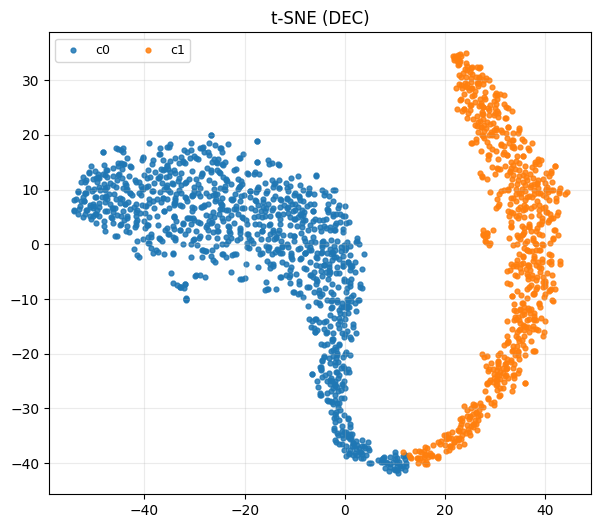

In [49]:
# ============================================================
# 4) BARRIDO DE K → KMeans → Inicializar centros → Entrenar DEC
#     - Estabilización de Z para métricas (RobustScaler + L2 norm)
#     - Evita RuntimeWarnings en CH/Sil/DB
#     - AMP (API nueva) para DEC
# ============================================================
from contextlib import nullcontext
from sklearn.preprocessing import RobustScaler, normalize

# --- AMP helpers (reusa firma de Celda 3; se redefinen aquí por si acaso) ---
def _amp_enabled():
    return bool(USE_AMP and DEVICE.type == "cuda")

def _amp_ctx():
    return torch.amp.autocast("cuda", dtype=torch.float16) if _amp_enabled() else nullcontext()

def _make_scaler():
    return torch.amp.GradScaler("cuda") if _amp_enabled() else None

# --- utilidades de métricas y t-SNE (parámetros explícitos) ---
def _safe_metric(fn, *args):
    try:
        return fn(*args)
    except Exception:
        return float('nan')

def _stabilize_for_metrics(Z_in: np.ndarray) -> np.ndarray:
    """Para evaluar métricas internas: robust scale + L2 row-norm + float64."""
    Z = np.asarray(Z_in, dtype=np.float64)
    Z = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(5, 95)).fit_transform(Z)
    Z = normalize(Z, norm='l2')
    return Z

def show_tsne(Z, y, title="t-SNE (Z)"):
    if not RUN_TSNE_2D:
        return
    n = Z.shape[0]
    if n < 10:
        print("t-SNE omitido (muy pocas muestras)."); return
    perp = max(5, min(TSNE_PERPLEXITY, (n - 1) // 3))
    Z2 = TSNE(
        n_components=2,
        perplexity=perp,
        learning_rate="auto",
        init="pca",
        n_iter=1000,          # parámetro válido en sklearn
        angle=0.5,
        method="barnes_hut",
        metric="euclidean",
        random_state=SEED,
        verbose=0
    ).fit_transform(np.asarray(Z, dtype=np.float64))
    plt.figure(figsize=(7,6))
    for k in sorted(np.unique(y)):
        idx = (y == k)
        plt.scatter(Z2[idx,0], Z2[idx,1], s=12, alpha=0.85, label=f"c{k}")
    plt.title(title); plt.grid(True, alpha=0.25); plt.legend(ncol=2, fontsize=9)
    plt.show()

# --- Barrido de K ROBUSTO: varias semillas, métricas en Z estabilizado ---
def sweep_k_robust(Z_all_raw,
                   ks=range(K_MIN, K_MAX+1),
                   repeats=7,
                   base_seed=K_RANDOM_STATE):
    """
    - Usa TODO el dataset (sin muestreo).
    - Para cada K corre `repeats` semillas distintas y promedia métricas:
        silhouette (↑), calinski_harabasz (↑, combinamos como log1p),
        davies_bouldin (↓).
    - Penaliza la inestabilidad (std entre semillas).
    - Devuelve K* + Z_raw + Z_estab para etapas siguientes.
    """
    Z_raw   = np.ascontiguousarray(np.asarray(Z_all_raw, dtype=np.float64))
    Z_estab = _stabilize_for_metrics(Z_raw)

    print("\n=== Barrido K (robusto, métricas en Z estabilizado) ===")
    print(" K |  Sil(mean)±std |  CH_log(mean)±std |  DB(mean)±std ")

    rows = []
    for k in ks:
        sils, chs, dbs = [], [], []
        for r in range(repeats):
            seed = int(base_seed + 9973*r)
            km = _kmeans(k, random_state=seed)  # helper de Celda 0 (n_init seguro)
            labels = km.fit_predict(Z_estab)

            if len(np.unique(labels)) < 2:
                sil, ch, db = np.nan, np.nan, np.nan
            else:
                sil = silhouette_score(Z_estab, labels, metric="euclidean")
                ch  = calinski_harabasz_score(Z_estab, labels)
                db  = davies_bouldin_score(Z_estab, labels)

            sils.append(sil)
            chs.append(ch)
            dbs.append(db)

        # medias y desvios (manejo de NaN)
        sil_mean, sil_std = (np.nanmean(sils), np.nanstd(sils))
        ch_mean,  ch_std  = (np.nanmean(chs),  np.nanstd(chs))
        db_mean,  db_std  = (np.nanmean(dbs),  np.nanstd(dbs))

        ch_log_mean = np.log1p(ch_mean) if np.isfinite(ch_mean) and ch_mean > 0 else np.nan
        ch_log_std  = (np.nan if not (np.isfinite(ch_std) and ch_mean > 0)
                       else ch_std / (1.0 + ch_mean))  # aprox a std de log1p

        print(f"{k:2d} | {sil_mean:>7.4f}±{sil_std:<6.4f} | {ch_log_mean:>12.4f}±{(0.0 if np.isnan(ch_log_std) else ch_log_std):<6.4f} | {db_mean:>7.4f}±{db_std:<6.4f}")

        rows.append({
            "k": k,
            "sil_mean": sil_mean, "sil_std": sil_std,
            "ch_log_mean": ch_log_mean, "ch_log_std": ch_log_std if np.isfinite(ch_log_std) else np.nan,
            "db_mean": db_mean, "db_std": db_std
        })

    # z-score robusto (ignora NaNs) y penalización por inestabilidad
    def _z(x):
        x = np.array(x, dtype=np.float64)
        m, s = np.nanmean(x), np.nanstd(x)
        if not np.isfinite(s) or s < 1e-12: return np.zeros_like(x)
        z = (x - m) / s; z[~np.isfinite(z)] = 0.0; return z

    K_vals     = np.array([r["k"] for r in rows])
    sil_mu     = np.array([r["sil_mean"] for r in rows], dtype=np.float64)
    chlog_mu   = np.array([r["ch_log_mean"] for r in rows], dtype=np.float64)
    db_mu      = np.array([r["db_mean"] for r in rows], dtype=np.float64)
    sil_sd     = np.array([r["sil_std"] for r in rows], dtype=np.float64)
    chlog_sd   = np.array([r["ch_log_std"] for r in rows], dtype=np.float64)
    db_sd      = np.array([r["db_std"] for r in rows], dtype=np.float64)

    # score combinado: ↑ sil_mu, ↑ ch_log_mu, ↓ db_mu  y  penaliza varianza: ↓ sil_sd, ↓ chlog_sd, ↓ db_sd
    score = _z(sil_mu) + _z(chlog_mu) + _z(-db_mu) + 0.5*(_z(-sil_sd) + _z(-chlog_sd) + _z(-db_sd))
    k_star = int(K_vals[int(np.nanargmax(score))])
    print(f"\n→ K* (robusto) = {k_star}  |  (repeats={repeats})")
    return {"k": k_star, "Z_raw": Z_raw, "Z_estab": Z_estab}

# --- usar el barrido robusto (toda la población, multip. semillas) ---
ks_range = range(K_MIN, K_MAX+1)  # o range(3, 10+1) si lo prefieres directo
sel = sweep_k_robust(Z_all, ks=ks_range, repeats=7, base_seed=K_RANDOM_STATE)
K_OPT  = int(sel["k"]); Z_raw = sel["Z_raw"]; Z_estab = sel["Z_estab"]

# --- re-ajusta KMeans en Z_raw para inicializar centros (más 'n_init') ---
try:
    kmeans_raw = KMeans(n_clusters=K_OPT, n_init="auto", random_state=K_RANDOM_STATE)
except TypeError:
    kmeans_raw = KMeans(n_clusters=K_OPT, n_init=50, random_state=K_RANDOM_STATE)

kmeans_raw.fit(Z_raw)
centers = kmeans_raw.cluster_centers_

cluster_layer = ClusteringLayer(n_clusters=K_OPT, latent_dim=LATENT_DIM, alpha=1.0).to(DEVICE)
cluster_layer.set_centers(centers)
print(f"[INIT] Centros iniciales fijados (K={K_OPT})")


# --- Loaders indexados (batch → índice global) ---
class IndexDataset(Dataset):
    def __init__(self, base): self.base = base
    def __len__(self): return len(self.base)
    def __getitem__(self, i):
        x, _ = self.base[i]; return x, i

def make_index_loader(ds, bs=BATCH_DEC, shuffle=True):
    return DataLoader(IndexDataset(ds), batch_size=bs, shuffle=shuffle,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                      persistent_workers=(NUM_WORKERS > 0 and PERSISTENT_WORKERS),
                      drop_last=False)

dl_all_ordered  = make_index_loader(ds_all, bs=BATCH_DEC, shuffle=False)
dl_all_shuffled = make_index_loader(ds_all, bs=BATCH_DEC, shuffle=True)

# --- Funciones DEC: Q, P, métricas (usando Z estabilizado para métricas) ---
@torch.no_grad()
def compute_q_all(encoder, cl_layer, dl_ordered, device=DEVICE):
    encoder.eval(); cl_layer.eval()
    Qs, Zs = [], []
    for xb, idx in dl_ordered:
        xb = xb.to(device, non_blocking=True)
        with _amp_ctx():
            z = encoder(xb)
            q = cl_layer(z)
        q = torch.clamp(q, 1e-8, 1.0); q = q / q.sum(dim=1, keepdim=True)
        Qs.append(q.detach().cpu()); Zs.append(z.detach().cpu())
    Q = torch.cat(Qs, dim=0).numpy()
    Z = torch.cat(Zs, dim=0).numpy()
    return Q, Z

def target_distribution(Q_torch):
    weight = (Q_torch ** 2) / torch.sum(Q_torch, dim=0, keepdim=True)
    P = weight / torch.sum(weight, dim=1, keepdim=True)
    P = torch.clamp(P, 1e-8, 1.0); P = P / P.sum(dim=1, keepdim=True)
    return P

def cluster_metrics(Z_raw_np, y):
    """Métricas en Z estabilizado para evitar overflows/NaN."""
    Zm = _stabilize_for_metrics(Z_raw_np)
    sil = _safe_metric(silhouette_score, Zm, y)
    ch  = _safe_metric(calinski_harabasz_score, Zm, y)
    db  = _safe_metric(davies_bouldin_score, Zm, y)
    return sil, ch, db

# --- Entrenamiento DEC: minimiza KL(P||Q) sobre encoder + centros ---
def dec_train(ae, cl_layer, dl_ordered, dl_shuffled,
              epochs=DEC_EPOCHS, lr=DEC_LR, wd=DEC_WD,
              update_interval=DEC_UPDATE_INT, tol=DEC_TOL,
              use_amp=USE_AMP, device=DEVICE):
    ae.encoder.to(device); cl_layer.to(device)
    opt = torch.optim.AdamW(list(ae.encoder.parameters()) + list(cl_layer.parameters()), lr=lr, weight_decay=wd)
    scaler = _make_scaler()
    history = {"kl": [], "silhouette": [], "ch": [], "db": []}
    y_prev = None

    for ep in range(1, epochs+1):
        # E: calcula Q y P en TODO el set + métricas (en Z estabilizado)
        Q_np, Z_raw_np = compute_q_all(ae.encoder, cl_layer, dl_ordered, device)
        Q = torch.from_numpy(Q_np)
        P = target_distribution(Q)
        y_curr = Q_np.argmax(axis=1)
        sil, ch, db = cluster_metrics(Z_raw_np, y_curr)
        history["silhouette"].append(sil); history["ch"].append(ch); history["db"].append(db)

        if y_prev is not None:
            delta = (y_prev != y_curr).sum() / float(len(y_curr))
            print(f"[DEC] ep {ep:02d}  Δasig={delta:.4f} | sil={sil:.4f} ch={ch:.1f} db={db:.4f}")
            if delta < tol and ep > 5:
                print("[DEC] Convergencia por estabilidad."); break
        else:
            print(f"[DEC] ep {ep:02d}  sil={sil:.4f} ch={ch:.1f} db={db:.4f}")
        y_prev = y_curr

        # M: optimiza KL(P||Q) por mini-batches
        ae.encoder.train(); cl_layer.train()
        kl_epoch, n_batches = 0.0, 0
        for xb, idx in tqdm(dl_shuffled, desc=f"[DEC][{ep:02d}/{epochs}] KL", leave=False):
            xb  = xb.to(device, non_blocking=True)
            idx = idx.long()
            with _amp_ctx():
                z = ae.encoder(xb)
                q = cl_layer(z)
                q = torch.clamp(q, 1e-8, 1.0); q = q / q.sum(dim=1, keepdim=True)
                p = P[idx].to(device)
                loss = F.kl_div(q.log(), p, reduction="batchmean")

            if scaler is not None:
                opt.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update()
            else:
                opt.zero_grad(set_to_none=True)
                loss.backward(); opt.step()

            kl_epoch += loss.item(); n_batches += 1

        history["kl"].append(kl_epoch / max(1, n_batches))
        torch.cuda.empty_cache(); gc.collect()

    Q_final, Z_final = compute_q_all(ae.encoder, cl_layer, dl_ordered, device)
    y_final = Q_final.argmax(axis=1)
    print(f"[DEC] Clusters finales: {dict(Counter(y_final.tolist()))}")
    return {"Q": Q_final, "Z": Z_final, "y": y_final, "history": history}

# --- Ejecutar DEC ---
RESULT_DEC = dec_train(ae, cluster_layer, dl_all_ordered, dl_all_shuffled,
                       epochs=DEC_EPOCHS, lr=DEC_LR, wd=DEC_WD,
                       update_interval=DEC_UPDATE_INT, tol=DEC_TOL,
                       use_amp=USE_AMP, device=DEVICE)

# --- Métricas finales + t-SNE ---
sil = _safe_metric(silhouette_score, _stabilize_for_metrics(RESULT_DEC["Z"]), RESULT_DEC["y"])
ch  = _safe_metric(calinski_harabasz_score, _stabilize_for_metrics(RESULT_DEC["Z"]), RESULT_DEC["y"])
db  = _safe_metric(davies_bouldin_score,   _stabilize_for_metrics(RESULT_DEC["Z"]), RESULT_DEC["y"])
print(f"[DEC] Final (métricas en Z estabilizado): Sil={sil:.4f} | CH={ch:.1f} | DB={db:.4f}")

show_tsne(RESULT_DEC["Z"], RESULT_DEC["y"], title="t-SNE (DEC)")
